In [74]:
import pandas as pd
import numpy as np
import requests
import bs4
from bs4 import BeautifulSoup
from tflearn.data_utils import to_categorical
from collections import Counter, defaultdict
from sklearn.feature_extraction import stop_words

In [75]:
results = pd.read_csv('indeed-results.csv')
results.head()

,location,title,company,salary,summary
0,"New York, NY 10261 (Murray Hill area)",Data Scientist,MassMutual Financial Group,NaN,MassMutual’s Advanced Analytics group is seeki...
1,"New York, NY",Data Scientist,HarperCollins Publishers Inc.,NaN,"Uses mid to large-scale machine learning, data..."
2,"New York, NY 10016 (Gramercy area)",Data Scientist,Simulmedia,NaN,You will find yourself working with other data...
3,"New York, NY",Data Science Analyst,AIG,NaN,§ Stay current on the latest machine learning ...
4,"New York, NY",Data Scientist,PulsePoint,NaN,"MS/PhD in Astronomy, Physics, Applied Mathemat..."


In [76]:
results.shape

(12745, 5)

## Data Wrangling & Preprocessing


In [77]:
salaries_sal = results[results.salary.notnull()]
salaries_summ = salaries_sal[salaries_sal.summary.notnull()]
salaries = salaries_summ[salaries_summ.company.notnull()]

In [78]:
salaries.dtypes

location    object
title       object
company     object
salary      object
summary     object
dtype: object

In [79]:
salaries.head()

,location,title,company,salary,summary
24,"New York, NY",Data Scientist,indify,"$90,000 - $170,000 a year",Indify data scientists contribute to all aspec...
50,"New York, NY 10031 (Hamilton Heights area)",Computer Science (Data Analysis) Instructor,"Urban Scholars Program, City College of Ne...",$40 an hour,"Data, data filtering, basic spreadsheet operat..."
63,"New York, NY",Data Scientist,WorldCover,"$70,000 - $110,000 a year",Your primary focus will be in applying data mi...
79,"New York, NY",Data Scientist,Scienaptic Systems Inc,"$100,000 a year","As our representative in front of client, you ..."
98,"New York, NY 10038 (Financial District area)",Data Scientist,Enterprise Select,"$130,000 a year",Deep knowledge of applied statistics and machi...


In [80]:
salaries.shape

(686, 5)

In [81]:
salaries = salaries[(~salaries.salary.str.contains('an hour')) & (~salaries.salary.str.contains('a month'))
                   & (~salaries.salary.str.contains('a week')) & (~salaries.salary.str.contains('a day'))]

In [82]:
salaries.salary = salaries.salary.str.replace('a year', '').str.replace(',', '').str.replace('$', '')

In [83]:
salaries.shape

(494, 5)

In [84]:
for i in salaries.salary:
    if len(i.split('-')) != 1 and len(i.split('-')) != 2:
        print(i)

In [85]:
new_salaries = []
for i in salaries.salary:
    a = i.split('-')
    if len(a) == 2:
        new_salaries.append(np.mean([float(b) for b in a]))
    else:
        new_salaries.append(float(a[0]))

In [86]:
new_salaries[0:5]

[130000.0, 90000.0, 100000.0, 130000.0, 75000.0]

In [87]:
salaries.salary = new_salaries

In [88]:
salaries.head()

,location,title,company,salary,summary
24,"New York, NY",Data Scientist,indify,130000.0,Indify data scientists contribute to all aspec...
63,"New York, NY",Data Scientist,WorldCover,90000.0,Your primary focus will be in applying data mi...
79,"New York, NY",Data Scientist,Scienaptic Systems Inc,100000.0,"As our representative in front of client, you ..."
98,"New York, NY 10038 (Financial District area)",Data Scientist,Enterprise Select,130000.0,Deep knowledge of applied statistics and machi...
105,"New York, NY",Senior Research Analyst,Research Foundation of The City Univer...,75000.0,Overseeing all project activities related to d...


In [89]:
salaries.shape

(494, 5)

In [90]:
salaries.duplicated().sum()

0

In [91]:
salaries.isnull().sum()

location    0
title       0
company     0
salary      0
summary     0
dtype: int64

In [92]:
#display null columns

null_columns=salaries.columns[salaries.isnull().any()]
print(salaries[salaries.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [93]:
salaries.head()

,location,title,company,salary,summary
24,"New York, NY",Data Scientist,indify,130000.0,Indify data scientists contribute to all aspec...
63,"New York, NY",Data Scientist,WorldCover,90000.0,Your primary focus will be in applying data mi...
79,"New York, NY",Data Scientist,Scienaptic Systems Inc,100000.0,"As our representative in front of client, you ..."
98,"New York, NY 10038 (Financial District area)",Data Scientist,Enterprise Select,130000.0,Deep knowledge of applied statistics and machi...
105,"New York, NY",Senior Research Analyst,Research Foundation of The City Univer...,75000.0,Overseeing all project activities related to d...


In [94]:
##### dist plotting

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


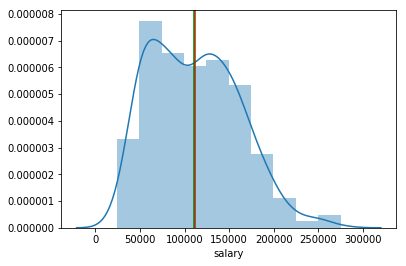

In [96]:
ax = sns.distplot(salaries['salary'], bins=10)
ax.axvline(salaries['salary'].mean(), c='r')
ax.axvline(salaries['salary'].median(), c='g')

In [97]:
twentieth = salaries['salary'].quantile(0.20)
eightieth = salaries['salary'].quantile(0.80)

In [98]:
median_salary = np.median(salaries.salary)
median_salary

110000.0

In [99]:
salaries['high_salary'] = [1 if i > median_salary else 0 for i in salaries.salary]

## Pre processing for vectorization

In [100]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split

In [101]:
## Count Number of words in each summary of job

salaries['word_count'] = salaries['summary'].apply(lambda x: len(str(x).split(" ")))
salaries[['summary','word_count']].head()

,summary,word_count
24,Indify data scientists contribute to all aspec...,24
63,Your primary focus will be in applying data mi...,22
79,"As our representative in front of client, you ...",26
98,Deep knowledge of applied statistics and machi...,21
105,Overseeing all project activities related to d...,20


In [102]:
## Count Number of characters in each summary of job

salaries['char_count'] = salaries['summary'].str.len() ## this also includes spaces
salaries[['summary','char_count']].head()

,summary,char_count
24,Indify data scientists contribute to all aspec...,143
63,Your primary focus will be in applying data mi...,158
79,"As our representative in front of client, you ...",162
98,Deep knowledge of applied statistics and machi...,161
105,Overseeing all project activities related to d...,153


In [103]:
#check for stop words

import nltk
#nltk.download()
from nltk.corpus import stopwords
stop = stopwords.words('english')

salaries['stopwords'] = salaries['summary'].apply(lambda x: len([x for x in x.split() if x in stop]))
salaries[['summary','stopwords']].head()

,summary,stopwords
24,Indify data scientists contribute to all aspec...,12
63,Your primary focus will be in applying data mi...,6
79,"As our representative in front of client, you ...",11
98,Deep knowledge of applied statistics and machi...,6
105,Overseeing all project activities related to d...,5


In [104]:
## make everything lowercase

salaries['summary'] = salaries['summary'].apply(lambda x: x.lower())
salaries['summary'].head()

24     indify data scientists contribute to all aspec...
63     your primary focus will be in applying data mi...
79     as our representative in front of client, you ...
98     deep knowledge of applied statistics and machi...
105    overseeing all project activities related to d...
Name: summary, dtype: object

In [105]:
salaries['title'] = salaries['title'].apply(lambda x: x.lower())
salaries['title'].head(10)

24                                        data scientist
63                                        data scientist
79                                        data scientist
98                                        data scientist
105                              senior research analyst
111                                 data analyst/modeler
136                                       data scientist
140                 data scientist (people analytics/hr)
141    data scientist for data- driven healthtech com...
159                            machine learning engineer
Name: title, dtype: object

In [106]:
salaries['title'] = salaries['title'].str.replace('[^\w\s]',' ')
salaries['title'].head(20)

24                                        data scientist
63                                        data scientist
79                                        data scientist
98                                        data scientist
105                              senior research analyst
111                                 data analyst modeler
136                                       data scientist
140                 data scientist  people analytics hr 
141    data scientist for data  driven healthtech com...
159                            machine learning engineer
171    environmental analyst  bureau of environmental...
176    research scientist for data integrity  world t...
197                                         data analyst
229                                      vp data science
244       data scientist needed for disruptive tech firm
245             bioinformatics scientist  data scientist
252                             project associate  equal
253            python backend w

In [107]:
# Remove punctuations

salaries['summary'] = salaries['summary'].str.replace('[^\w\s]','')
salaries['summary'].head()


24     indify data scientists contribute to all aspec...
63     your primary focus will be in applying data mi...
79     as our representative in front of client you w...
98     deep knowledge of applied statistics and machi...
105    overseeing all project activities related to d...
Name: summary, dtype: object

In [108]:
import re
states = ['IA', 'KS', 'UT', 'VA', 'NC', 'NE', 'SD', 'AL', 'ID', 'FM', 'DE', 'AK', 'CT', 'PR', 'NM', 'MS', 'PW', 'CO', 'NJ', 'FL', 'MN', 'VI', 'NV', 'AZ', 'WI', 'ND', 'PA', 'OK', 'KY', 'RI', 'NH', 'MO', 'ME', 'VT', 'GA', 'GU', 'AS', 'NY', 'CA', 'HI', 'IL', 'TN', 'MA', 'OH', 'MD', 'MI', 'WY', 'WA', 'OR', 'MH', 'SC', 'IN', 'LA', 'MP', 'DC', 'MT', 'AR', 'WV', 'TX']
regex = re.compile(r'\b(' + '|'.join(states) + r')\b')
salaries['location'] = salaries['location'].str.replace(',', '').str.extract(regex)

In [109]:
salaries['location'].head(10)

24     NY
63     NY
79     NY
98     NY
105    NY
111    NY
136    NY
140    NY
141    NY
159    NY
Name: location, dtype: object

In [110]:
# Check for rare words

freq = pd.Series(' '.join(salaries['summary']).split()).value_counts()[-10:]
freq

converge           1
4045k              1
aim                1
taking             1
sr                 1
02                 1
mainstream         1
physician          1
experimentation    1
transactional      1
dtype: int64

In [111]:
# Correct Spellings

# import textblob
# from textblob import TextBlob
# salaries['summary'][:5].apply(lambda x: str(TextBlob(x).correct()))

In [112]:
#Remove Stop words

stop = stopwords.words('english')
salaries['summary']  = salaries['summary'] .apply(lambda x: " ".join(x for x in x.split() if x not in stop))
salaries['summary'].head()

24     indify data scientists contribute aspects plat...
63     primary focus applying data mining techniques ...
79     representative front client opportunity constr...
98     deep knowledge applied statistics machine lear...
105    overseeing project activities related data col...
Name: summary, dtype: object

In [113]:
## Stemming

from nltk.stem import PorterStemmer
st = PorterStemmer()
salaries['summary'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
salaries['summary'].head()

24     indify data scientists contribute aspects plat...
63     primary focus applying data mining techniques ...
79     representative front client opportunity constr...
98     deep knowledge applied statistics machine lear...
105    overseeing project activities related data col...
Name: summary, dtype: object

In [114]:
## Lemmatization

from textblob import Word
salaries['summary'] = salaries['summary'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
salaries['summary'].head()

24     indify data scientist contribute aspect platfo...
63     primary focus applying data mining technique s...
79     representative front client opportunity constr...
98     deep knowledge applied statistic machine learn...
105    overseeing project activity related data colle...
Name: summary, dtype: object

In [115]:
###replace everything except the letters and numbers in the spaces.


salaries['summary'] = salaries['summary'].replace('[^a-zA-Z0-9]', ' ', regex = True)
salaries['summary'].head(5)


24     indify data scientist contribute aspect platfo...
63     primary focus applying data mining technique s...
79     representative front client opportunity constr...
98     deep knowledge applied statistic machine learn...
105    overseeing project activity related data colle...
Name: summary, dtype: object

In [116]:
salaries.shape

(494, 9)

In [117]:
salaries.summary.count()

494

In [118]:
#reset Index

salaries.reset_index(drop= True, inplace=True)
#salaries.head(40)


In [119]:
salaries.location.value_counts().index

Index(['CA', 'NY', 'IL', 'MA', 'TX', 'PA', 'DC', 'MO', 'FL', 'AZ', 'WA', 'VA',
       'OH', 'GA', 'OR', 'CO', 'MD', 'NC', 'IN', 'MN', 'TN', 'NJ', 'DE'],
      dtype='object')

## Vectorize Summary column using Tfidf Vectorizer & apply PCA

In [120]:
# from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
# vectorizer = TfidfVectorizer()
# X_tfidf = vectorizer.fit_transform(X_train) 
# print(X_tfidf)
# vect = CountVectorizer().fit(X_train)
# vect

In [121]:

# used words (axis in our multi-dimensional space)
# vectorizer.get_feature_names()[::2]


In [122]:
# from sklearn.decomposition import PCA
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.pipeline import Pipeline
# pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
# ])        
# Xtrain = pipeline.fit_transform(X_train).todense()
# Xtest = pipeline.fit_transform(X_test).todense()

# pca_xtrain = PCA(n_components=1).fit(Xtrain)
# pca_xtest = PCA(n_components=1).fit(Xtest)

# X_train_data = pca_xtrain.transform(Xtrain)
# X_test_data = pca_xtest.transform(Xtest)

# X_train_data
#plt.scatter(data2D[:,0], data2D[:,1], c='r')
#plt.show() 

### Split Train and Test Data

In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(salaries['summary'], salaries['salary'],test_size = 0.33,random_state = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
X_train.head()

(330,)
(164,)
(330,)
(164,)


81     associate data scientist exciting opportunity ...
353    pattern recognition machine learning data mini...
301    fast growing data analytics consulting shop lo...
171    data scientist director retail statistical met...
465    background python r machine learning hadoop sp...
Name: summary, dtype: object

In [124]:
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry: 

 indify data scientist contribute aspect platform vital part envisioning creating future product


X_train shape:  (330,)


### Apply CountVectorizer & TfidfVectorizer

In [125]:
# CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer().fit(X_train)

In [126]:
vect.get_feature_names()[::300]

['02', 'compliance', 'ground', 'opened', 'smith']

In [127]:
len(vect.get_feature_names())

1405

In [128]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<330x1405 sparse matrix of type '<class 'numpy.int64'>'
	with 4483 stored elements in Compressed Sparse Row format>

In [129]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_vectorized, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [130]:
from sklearn.metrics import r2_score
predictions = model.predict(vect.transform(X_test))
print("R^2 score for Linear Regression: ",model.score(vect.transform(X_test), y_test))

R^2 score for Linear Regression:  0.16134814965729705


In [131]:
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['02']

Largest Coefs: 
['02']



In [132]:
#Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer(min_df = 5).fit(X_train)
len(vect.get_feature_names())

208

In [133]:
X_train_vectorized = vect.transform(X_train)

model = LinearRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))
print("R^2 score for Linear Regression: ",model.score(vect.transform(X_test), y_test))

R^2 score for Linear Regression:  -0.6382541693048629


In [134]:
cv = CountVectorizer(stop_words="english")
cv.fit(X_title)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [135]:
salaries_w_desc = salaries[salaries.summary.notnull()]

X_title = salaries_w_desc.title
y_title = salaries_w_desc.high_salary

In [136]:
X_title_trans = pd.DataFrame(cv.transform(X_title).todense(), columns=cv.get_feature_names())

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_title_trans, y_title, test_size=0.3, random_state=59)

In [138]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("R^2 score for Linear Regression: ",model.score(X_title_trans.as_matrix(), y_title.as_matrix()))

R^2 score for Linear Regression:  -1.2822647989512488e+24


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [139]:
X_loc = salaries_w_desc.title


In [140]:
salaries.location = pd.Categorical(salaries.location)
salaries['loc_code'] = salaries.location.cat.codes
columns = ['word_count','char_count','stopwords']
salaries.drop(columns, inplace=True, axis=1)
salaries.to_csv('indeed-results_final.csv', index=False, encoding='utf-8')

In [141]:
#columns = ['location','title', 'company', 'summary', 'high_salary', 'word_count','char_count','stopwords']
#remove white spaces in columns names:
final = pd.read_csv('indeed-results_final.csv')
final.head()
salaries_reg = final
salaries_reg.head()

,location,title,company,salary,summary,high_salary,loc_code
0,NY,data scientist,indify,130000.0,indify data scientist contribute aspect platfo...,1,15
1,NY,data scientist,WorldCover,90000.0,primary focus applying data mining technique s...,0,15
2,NY,data scientist,Scienaptic Systems Inc,100000.0,representative front client opportunity constr...,0,15
3,NY,data scientist,Enterprise Select,130000.0,deep knowledge applied statistic machine learn...,1,15
4,NY,senior research analyst,Research Foundation of The City Univer...,75000.0,overseeing project activity related data colle...,0,15


In [142]:

salaries_reg.columns



Index(['location', 'title', 'company', 'salary', 'summary', 'high_salary',
       'loc_code'],
      dtype='object')

In [143]:
# #drop unwated columns:
columns = ['location','title', 'company', 'summary', 'high_salary']
salaries_reg.drop(columns, inplace=True, axis=1)
salaries_reg = salaries_reg[['loc_code','salary']]
salaries_reg.head()

,loc_code,salary
0,15,130000.0
1,15,90000.0
2,15,100000.0
3,15,130000.0
4,15,75000.0


In [144]:
dis_x = salaries_reg.drop('salary', axis = 1)
dis_y = salaries_reg['salary']
#dis_x

In [145]:
X_train, X_test, y_train, y_test = train_test_split(dis_x, dis_y, test_size=0.2)

In [146]:
X_train.shape

(395, 1)

In [147]:
X_test.shape

(99, 1)

In [148]:
y_train.shape

(395,)

In [149]:
y_test.shape

(99,)

In [150]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
#print("R^2 score for Linear Regression: ",model.score(y_test,predictions))

In [151]:
#print("R^2 score for Linear Regression: ",model.score(y_test,predictions))

### Plot the Linear Regression Graph

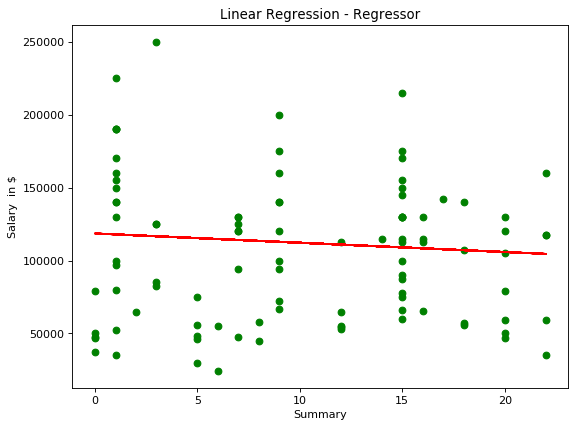

In [152]:
from matplotlib.pyplot import figure

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(X_test, y_test, c='g')
#plt.scatter(X_train, y_train)
plt.plot(X_test, predictions, c='r')
plt.title("Linear Regression - Regressor")
plt.xlabel("Summary")
plt.ylabel("Salary  in $")
plt.show()

## Apply Sigmoid function

[7.14248671 1.12930053]


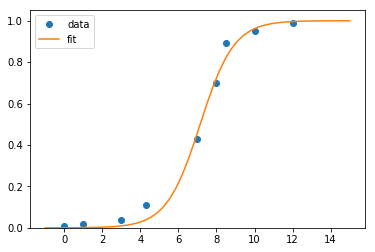

In [153]:
from scipy.optimize import curve_fit

def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y

xdata = np.array([0.0,   1.0,  3.0, 4.3, 7.0,   8.0,   8.5, 10.0, 12.0])
ydata = np.array([0.01, 0.02, 0.04, 0.11, 0.43,  0.7, 0.89, 0.95, 0.99])
#ydata = dis_x
#xdata = np.array([dis_y])

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print (popt)

x = np.linspace(-1, 15, 50)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.plot(x,y, label='fit')
plt.ylim(0, 1.05)
plt.legend(loc='best')
plt.show()

In [154]:
#city_dummies = pd.get_dummies(salaries.location)
salaries = salaries[['location','title','company','summary', 'salary', 'loc_code','high_salary']]
salaries.head()


,location,title,company,summary,salary,loc_code,high_salary
0,NY,data scientist,indify,indify data scientist contribute aspect platfo...,130000.0,15,1
1,NY,data scientist,WorldCover,primary focus applying data mining technique s...,90000.0,15,0
2,NY,data scientist,Scienaptic Systems Inc,representative front client opportunity constr...,100000.0,15,0
3,NY,data scientist,Enterprise Select,deep knowledge applied statistic machine learn...,130000.0,15,1
4,NY,senior research analyst,Research Foundation of The City Univer...,overseeing project activity related data colle...,75000.0,15,0


In [155]:
salaries.company = pd.Categorical(salaries.company)
salaries['comp_code'] = salaries.company.cat.codes
salaries= salaries[['location','title','company','summary','salary','loc_code','comp_code','high_salary']]
salaries.head()
salaries.shape

(494, 8)

### Assigning High salary and Low salary based on Median values

In [156]:
salaries['high_salary'] = [1 if i > median_salary else 0 for i in salaries.salary]

In [157]:
salaries.head()

,location,title,company,summary,salary,loc_code,comp_code,high_salary
0,NY,data scientist,indify,indify data scientist contribute aspect platfo...,130000.0,15,234,1
1,NY,data scientist,WorldCover,primary focus applying data mining technique s...,90000.0,15,229,0
2,NY,data scientist,Scienaptic Systems Inc,representative front client opportunity constr...,100000.0,15,204,0
3,NY,data scientist,Enterprise Select,deep knowledge applied statistic machine learn...,130000.0,15,140,1
4,NY,senior research analyst,Research Foundation of The City Univer...,overseeing project activity related data colle...,75000.0,15,54,0


## Plotting the Salary vs Location graph

Text(0,0.5,'Salary')

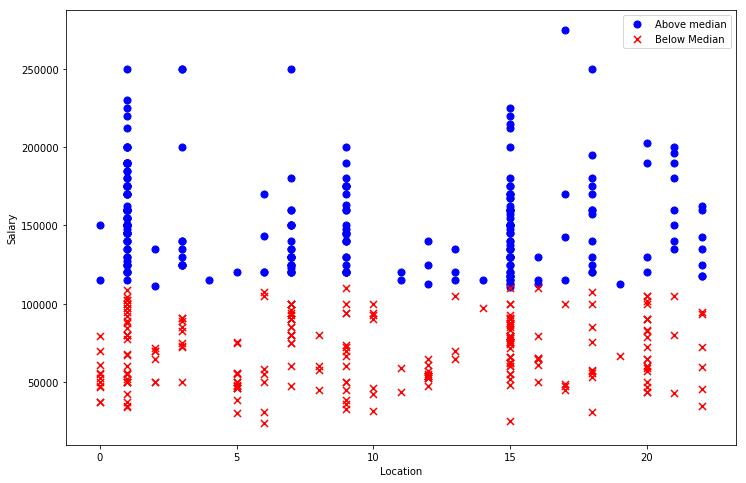

In [158]:
positive = salaries[salaries['high_salary'].isin([1])]  
negative = salaries[salaries['high_salary'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(positive['loc_code'], positive['salary'], s=50, c='b', marker='o', label='Above median')  
ax.scatter(negative['loc_code'], negative['salary'], s=50, c='r', marker='x', label='Below Median')  
ax.legend()  
ax.set_xlabel('Location')  
ax.set_ylabel('Salary')  

In [159]:
salaries_w_desc = salaries[salaries.summary.notnull()]

X_title = salaries_w_desc.title
y_title = salaries_w_desc.high_salary

In [160]:
salaries.head()

,location,title,company,summary,salary,loc_code,comp_code,high_salary
0,NY,data scientist,indify,indify data scientist contribute aspect platfo...,130000.0,15,234,1
1,NY,data scientist,WorldCover,primary focus applying data mining technique s...,90000.0,15,229,0
2,NY,data scientist,Scienaptic Systems Inc,representative front client opportunity constr...,100000.0,15,204,0
3,NY,data scientist,Enterprise Select,deep knowledge applied statistic machine learn...,130000.0,15,140,1
4,NY,senior research analyst,Research Foundation of The City Univer...,overseeing project activity related data colle...,75000.0,15,54,0


## Applying Logistic regression for Title vs High Salary

In [161]:
cv = CountVectorizer(stop_words="english")
cv.fit(X_title)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [162]:
len(cv.get_feature_names())

480

In [163]:
X_title_trans = pd.DataFrame(cv.transform(X_title).todense(), columns=cv.get_feature_names())

In [164]:
X_train, X_test, y_train, y_test = train_test_split(np.asmatrix(X_title_trans), y_title, test_size=0.3,
                                                    random_state=59)

In [165]:
# Applying Logistic regression
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression()
regressor.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [166]:
y_pred = regressor.predict(X_test)
y_pred

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])

### Predicting the accuracy score

In [167]:
# Predicting the accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.8053691275167785

In [169]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.8        0.81081081]
recall: [0.81081081 0.8       ]
fscore: [0.80536913 0.80536913]
support: [74 75]


In [171]:
filtered_data = salaries

## Applying Logistic regression for Salary, Location and Company vs High Salary

In [172]:
X = filtered_data.iloc[:,4:7]
y = filtered_data.iloc[:,-1]
X.head()

,salary,loc_code,comp_code
0,130000.0,15,234
1,90000.0,15,229
2,100000.0,15,204
3,130000.0,15,140
4,75000.0,15,54


In [173]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        
    return result

result = normalize(X)
result.head(10)

,salary,loc_code,comp_code
0,0.422311,0.681818,1.000000
1,0.262948,0.681818,0.978632
2,0.302789,0.681818,0.871795
3,0.422311,0.681818,0.598291
4,0.203187,0.681818,0.230769
5,0.205408,0.681818,0.081197
6,0.501992,0.681818,0.837607
7,0.760956,0.681818,0.452991
8,0.452191,0.681818,0.452991
9,0.422311,0.681818,0.098291


In [174]:
y.head()

0    1
1    0
2    0
3    1
4    0
Name: high_salary, dtype: int64

In [175]:
#Splitting the dataset into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

X_train.shape

(395, 3)

In [176]:
y_train.shape

(395,)

In [177]:
y_test.shape

(99,)

In [178]:
# Applying Logistic regression
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression()
regressor.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [179]:
# Predicting the test results
y_pred = regressor.predict(X_test)
y_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

### Predicting the accuracy score

In [180]:
# Predicting the accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.7474747474747475

In [181]:
from sklearn.metrics import precision_recall_fscore_support as score


precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.86046512 0.66071429]
recall: [0.66071429 0.86046512]
fscore: [0.74747475 0.74747475]
support: [56 43]


## Applying Logistic regression for Salary, Location vs High Salary

In [182]:
X = filtered_data.iloc[:,4:6]
y = filtered_data.iloc[:,-1]
X.head()

,salary,loc_code
0,130000.0,15
1,90000.0,15
2,100000.0,15
3,130000.0,15
4,75000.0,15


In [183]:
result = normalize(X)
result.head(10)

,salary,loc_code
0,0.422311,0.681818
1,0.262948,0.681818
2,0.302789,0.681818
3,0.422311,0.681818
4,0.203187,0.681818
5,0.205408,0.681818
6,0.501992,0.681818
7,0.760956,0.681818
8,0.452191,0.681818
9,0.422311,0.681818


In [184]:
#Splitting the dataset into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

X_train.shape

(395, 2)

In [185]:
# Applying Logistic regression
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression()
regressor.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [186]:
# Predicting the test results
y_pred = regressor.predict(X_test)
y_pred

array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Calculating Accuracy, Precision, Recall and FScores

In [187]:
# Predicting the accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.7070707070707071

In [ ]:
def predict_multi(X, thetas):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    preds = [sigmoid(X * np.asmatrix(t).T) for t in thetas]
    return np.column_stack(preds).argmax(axis=1)

thetas = [train(X_train, y_train[:,i]) for i in range(0,3)]
predictions = predict_multi(X_test, thetas) + 1

print('accuracy:', accuracy_score(y_test, predictions))
print('precision:', precision_score(y_test, predictions, average='macro'))
print('recall:', recall_score(y_test, predictions, average='macro'))

plot_points(X_train, y_train.argmax(axis=1))
plot_boundary(X_train, lambda x: predict_multi(x, thetas))

In [189]:
import numpy as np

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def cost(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]

    hyp = sigmoid(X.dot(theta))
    pos = np.multiply(-y, np.log(hyp))
    neg = np.multiply((1 - y), np.log(1 - hyp))

    return np.sum(pos - neg) / (len(X))

def gradient(theta, X, y):
    theta = theta[:,None]
    y = y[:,None]

    error = sigmoid(X.dot(theta)) - y
    return X.T.dot(error) / len(X)

In [ ]:
from scipy.optimize import fmin_tnc

def train(X, y):
    X = np.insert(X, 0, np.ones(len(X)), axis=1)
    theta = np.zeros(X.shape[1])
    result = fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))

    return result[0]

theta = train(X_train, y_train)
print('theta: ', theta)

In [191]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred, average='macro')

(0.7575757575757576, 0.7329734219269103, 0.7040511287496134, None)

In [192]:

precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.90909091 0.60606061]
recall: [0.53571429 0.93023256]
fscore: [0.6741573  0.73394495]
support: [56 43]
